# INSY 695 - Machine Learning Models

### Contents
**1. XGBoost**

**2. Comparison with Other ML Models**

**3. XGBoost with New Features**


**4. XGBoost with Hyperparameter Tuning**

In [2]:
import pandas as pd
import numpy as np
import os
import platform as pf
from IPython.display import display # Display data
pd.options.mode.chained_assignment = None  # default='warn'

import shap

import warnings
import itertools    
import statsmodels.api as sm

from datetime import timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import math
from scipy import stats

plt.style.use('fivethirtyeight')

## 1. Load Data 

In [3]:
import helper
from helper import *

df = load_and_preprocess()
df.head(3)

,datetime,Description,Humidity,Wind Direction,Temperature,Pressure,Wind Speed,clouds,rain,mist,snow,shower,thunderstorm,fog,other,Intensity
1,2012-10-01 13:00:00,heavy clouds,93.0,1001.0,285.83000,230.0,4.0,1,0,0,0,0,0,0,0,3.0
2,2012-10-01 14:00:00,sky is clear,91.0,986.0,285.83465,230.0,4.0,0,0,0,0,0,0,0,0,0.0
3,2012-10-01 15:00:00,sky is clear,87.0,945.0,285.84779,231.0,4.0,0,0,0,0,0,0,0,0,0.0


In [4]:
#need to specify datetime[ns] or else the rest will not run 
df['datetime'] = df['datetime'].astype('datetime64[ns]')
weather_df = df.set_index('datetime')
weather_df

,Description,Humidity,Wind Direction,Temperature,Pressure,Wind Speed,clouds,rain,mist,snow,shower,thunderstorm,fog,other,Intensity
datetime,,,,,,,,,,,,,,,
2012-10-01 13:00:00,heavy clouds,93.0,1001.0,285.830000,230.0,4.0,1,0,0,0,0,0,0,0,3.0
2012-10-01 14:00:00,sky is clear,91.0,986.0,285.834650,230.0,4.0,0,0,0,0,0,0,0,0,0.0
2012-10-01 15:00:00,sky is clear,87.0,945.0,285.847790,231.0,4.0,0,0,0,0,0,0,0,0,0.0
2012-10-01 16:00:00,sky is clear,84.0,904.0,285.860929,233.0,4.0,0,0,0,0,0,0,0,0,0.0
2012-10-01 17:00:00,sky is clear,80.0,863.0,285.874069,234.0,3.0,0,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-29 20:00:00,moderate clouds,64.0,1021.0,275.130000,300.0,10.0,1,0,0,0,0,0,0,0,2.0
2017-11-29 21:00:00,moderate clouds,59.0,1023.0,274.130000,300.0,7.0,1,0,0,0,0,0,0,0,2.0
2017-11-29 22:00:00,light clouds,66.0,1024.0,273.480000,290.0,7.0,1,0,0,0,0,0,0,0,1.0


<AxesSubplot:xlabel='datetime'>

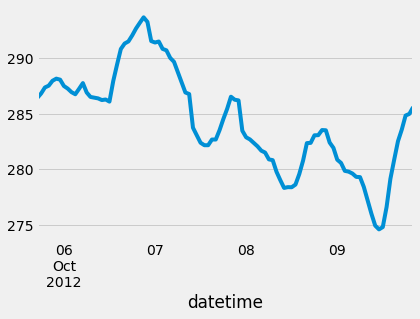

In [4]:
weather_df['Temperature'][100:200].plot()

<AxesSubplot:xlabel='datetime'>

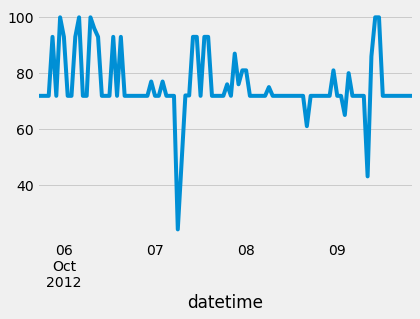

In [5]:
weather_df['Humidity'][100:200].plot()

<AxesSubplot:xlabel='datetime'>

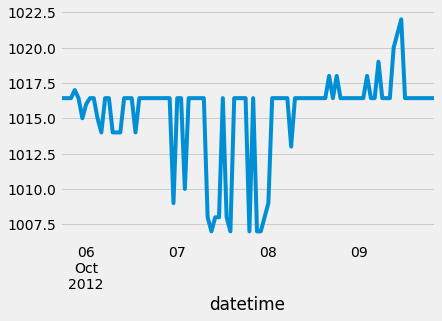

In [6]:
weather_df['Wind Direction'][100:200].plot()

<AxesSubplot:xlabel='datetime'>

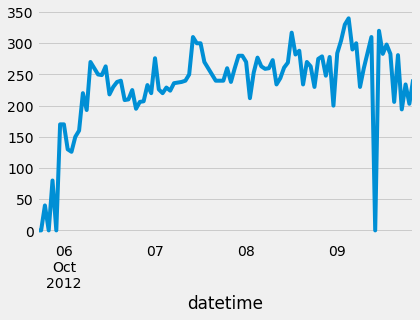

In [7]:
weather_df['Pressure'][100:200].plot()

## Model 1: XGBoost

We first create a base XGBoost model to benchmark other models against. The model will take simply the temperature and date columns as input.

In [8]:
ml_df = pd.DataFrame({'Temperature': weather_df['Temperature']}, index = weather_df.index)
ml_df

,Temperature
datetime,
2012-10-01 13:00:00,285.830000
2012-10-01 14:00:00,285.834650
2012-10-01 15:00:00,285.847790
2012-10-01 16:00:00,285.860929
2012-10-01 17:00:00,285.874069
...,...
2017-11-29 20:00:00,275.130000
2017-11-29 21:00:00,274.130000
2017-11-29 22:00:00,273.480000


**Create lagged attributes**

From this limited amount of information, we can create new variables such as the date, month, and year, which can give a sense of the cyclical nature of the time series. Then, we create lagged versions of the data -- i.e. the temperature from 1 hour, 2 hours, 12 hours, or 24 hours before.

In [9]:
#CREATE LAGGED ATTRIBUTES 

ml_df['date'] = ml_df.index
ml_df['month'] = ml_df['date'].dt.day
ml_df['month'] = ml_df['date'].dt.month
ml_df['year'] = ml_df['date'].dt.year

ml_df['lag1'] = ml_df['Temperature'].shift(periods = 1, fill_value = 0)
ml_df['lag2'] = ml_df['Temperature'].shift(periods = 2, fill_value = 0)
ml_df['lag12'] = ml_df['Temperature'].shift(periods = 12, fill_value = 0)
ml_df['lag24'] = ml_df['Temperature'].shift(periods = 24, fill_value = 0)

ml_df['avg_temp'] = 0 
for i in range(1, len(ml_df)):
    ml_df['avg_temp'][i] = ml_df['lag1'][:i+1].mean()
    

ml_df.drop('date', axis = 1, inplace = True)

#we have to eliminate all those with 0s
ml_df = ml_df[ml_df['lag24'] != 0]

In [10]:
X = ml_df.iloc[:,1:]
y = ml_df[['Temperature']]

In [11]:
X

,month,year,lag1,lag2,lag12,lag24,avg_temp
datetime,,,,,,,
2012-10-02 13:00:00,10,2012,286.123721,286.110581,285.979185,285.830000,274
2012-10-02 14:00:00,10,2012,286.136860,286.123721,285.992325,285.834650,274
2012-10-02 15:00:00,10,2012,286.150000,286.136860,286.005465,285.847790,275
2012-10-02 16:00:00,10,2012,287.550000,286.150000,286.018604,285.860929,275
2012-10-02 17:00:00,10,2012,288.140000,287.550000,286.031744,285.874069,276
...,...,...,...,...,...,...,...
2017-11-29 20:00:00,11,2017,276.450000,276.150000,275.380000,273.750000,280
2017-11-29 21:00:00,11,2017,275.130000,276.450000,277.450000,274.050000,280
2017-11-29 22:00:00,11,2017,274.130000,275.130000,278.770000,274.050000,280


**Split Data**

Here, we split the data in sequence of time, since the data is a time series. 

In [12]:
def train_test_split(data, n_test):
    return data[:n_test], data[n_test:]

split_len = int(len(weather_df)*0.80)

X_train, X_test = train_test_split(X, split_len)
y_train, y_test = train_test_split(y, split_len)

**Standardize Variables**

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled, columns = X_train.columns) #X_train_raw.columns?
X_train.columns = X.columns

X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled, columns = X_train.columns) #X_train_raw.columns?
X_train.columns = X.columns


In [16]:
X_train

,month,year,lag1,lag2,lag12,lag24,avg_temp
0,0.969616,-1.894039,0.481534,0.480436,0.469357,0.456781,-1.753930
1,0.969616,-1.894039,0.482619,0.481521,0.470442,0.457166,-1.753930
2,0.969616,-1.894039,0.483704,0.482607,0.471528,0.458251,-1.325868
3,0.969616,-1.894039,0.599362,0.483692,0.472613,0.459336,-1.325868
4,0.969616,-1.894039,0.648103,0.599349,0.473699,0.460422,-0.897806
...,...,...,...,...,...,...,...
36196,1.258538,1.388207,-0.201977,-0.286251,-0.371557,0.152777,0.814442
36197,1.258538,1.388207,-0.122669,-0.201987,-0.482256,0.210604,0.814442
36198,1.258538,1.388207,-0.041709,-0.122679,-0.514474,0.264300,0.814442
36199,1.258538,1.388207,0.064035,-0.041719,-0.621043,0.237865,0.814442


**Run XGBoost Model and generate RMSE**

In [17]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(n_estimators=1000)
xgb_model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              early_stopping_rounds=50,
              verbose=False) 

pred = xgb_model.predict(X_test)

In [18]:
ts_results = pd.DataFrame({'Predicted': pred, 'Observed': y_test['Temperature']})
ts_results[ts_results['Predicted'] <= 0] = 0
ts_results['RMSE'] = np.sqrt((ts_results['Predicted']-ts_results['Observed'])**2)
ts_results['RMSE'].mean()

0.6105905232613383

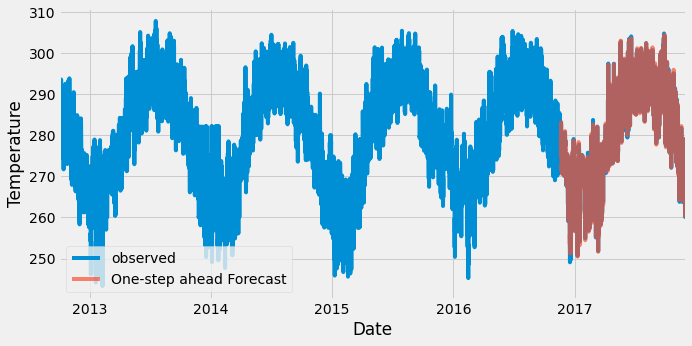

In [19]:
#plot real against predicted values
ax = weather_df['Temperature'].plot(label='observed')
ts_results['Predicted'].plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(10, 5))

ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
plt.legend()
plt.show()

In [20]:
ts_results.head(20).style.background_gradient(cmap='inferno')

,Predicted,Observed,RMSE
datetime,,,
2016-11-18 22:00:00,279.593292,279.150000,0.443292
2016-11-18 23:00:00,278.821808,277.840000,0.981808
2016-11-19 00:00:00,277.596008,278.150000,0.553992
2016-11-19 01:00:00,278.580017,278.150000,0.430017
2016-11-19 02:00:00,278.593811,277.440000,1.153811
2016-11-19 03:00:00,277.390137,277.460000,0.069863
2016-11-19 04:00:00,277.496918,277.150000,0.346918
2016-11-19 05:00:00,276.556122,276.460000,0.096122
2016-11-19 06:00:00,276.503723,275.800000,0.703723


### **Plot Feature Importances**

Here, we can see that the temperature at the hour before is the most important factor in predicting temperature, followed by two hours, 12 hours, and 24 hours before. This makes sense intuitively, given that the temperature at the most recent timesteps is more likely to be closely related to the temperature at the next timestep. 

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

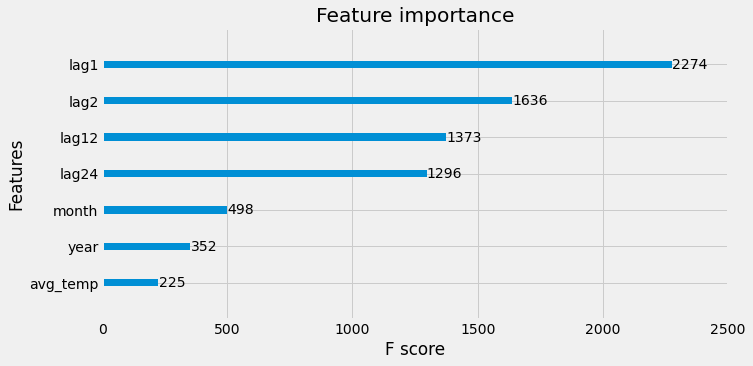

In [28]:
plt.figure(figsize=(10,5))
xgb.plot_importance(xgb_model, ax=plt.gca())

### **Model Explainability Using Shap**

In [26]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer.shap_values(X_train)

Below is shap summary plot and here is how you read it:
* Each dot is a training example


* **List of features** on the left is sorted in order of highest feature importance on the model's output (temperature). 
    * We see that indeed, lag1 is the most important feature (as indicated in the feature importance section above) and pretty similar order for the rest of the features. 
    * The colors (red and blue) represent the values (high to low) of the corresponding feature. 
    * Purple means that the feature is associated to both high and low ouputs.


* **The x-axis** values at the bottom, represent the shap values, which is the degree to how much strength the feature's high/low value is correlated on the target/output variable. 
    * **Lag1:** If we look at lag1 we observe that it's pretty symetrical overall and directly proportional, meaning that low values of lag1 is associated with lower temperature, while high values of lag1 is associated with higher temperatures. Both red and blue has more bulk in the lower ranges, while blue has more range than red in the further ranges (low values of lag1 is more associated with lower temperature than high values of lag1 in high temperature observations).
    * **Lag12:** On the other hand seem to correlate with lower temperatures more when its value is low, but not as much when its values are high with higher temperatures. There also seem to be lots of outlier like datapoints.

Note: In this plot, there is a bit of pertubation of values that sit close together for better visualization. 


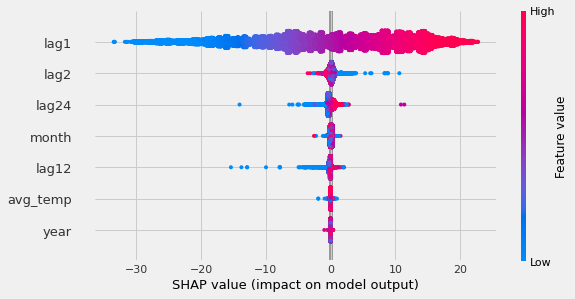

In [27]:
shap.summary_plot(shap_values, X_train)

If we want to zoom into 1 feature specific, we can use a dependence plot. Here we see more clearly what was already explained above about the lag1 feature.

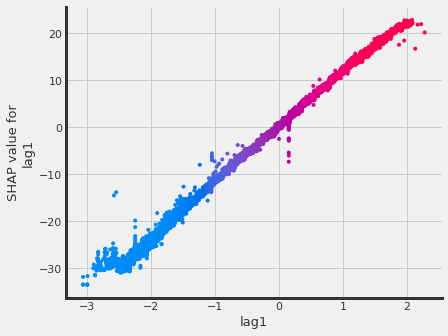

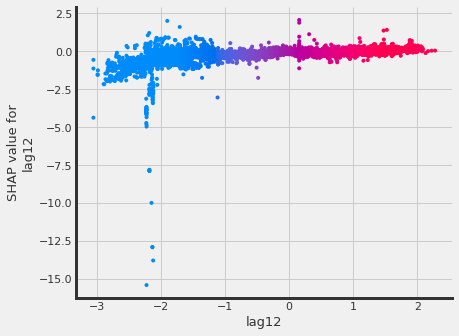

In [35]:
shap.dependence_plot("lag1", shap_values, X_train, interaction_index="lag1")
shap.dependence_plot("lag12", shap_values, X_train, interaction_index="lag12")

## Model 2: Compare Other Models

Using the similar logic as before, we can compare the performance of multiple other base models. Here, we can see that none of them models perform as well as the base XGBoost model.

In [90]:
#Import models' packages
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error


#Regression Models
regression_models = [['Linear Regression',LinearRegression()], 
                     ['RF regressor',RandomForestRegressor()], 
                     ['GBT',GradientBoostingRegressor()],
                     ['LASSO', Lasso()],
                     ['Ridge', Ridge()]]
                     

MSEs = []
MAEs = []
RMSEs = []
Models = ['Linear Regression', 'Random Forest Regressor', 'Gradient Boosting Regressor', 'Lasso', 'Ridge']

for name, model in regression_models: 
    print('Model = ', name)
    model.fit(X_train, y_train.values.ravel())
    y_test_pred = model.predict(X_test)
    
    MSE = mean_squared_error(y_test, y_test_pred)
    MAE = mean_absolute_error(y_test, y_test_pred)
    RMSE = np.sqrt(MSE)
    
    MSEs.append(MSE)
    MAEs.append(MAE)
    RMSEs.append(RMSE)
    print("MSE: ", MSE)
    print("RMSE: ", RMSE)
    print("MAE: ", MAE)
    print("-" * 19)

Model =  Linear Regression
MSE:  0.7809309598028665
RMSE:  0.8837029816645786
MAE:  0.6228986473492575
-------------------
Model =  RF regressor
MSE:  0.7523597696592069
RMSE:  0.8673867474542177
MAE:  0.6095352784778607
-------------------
Model =  GBT
MSE:  0.8679987114603378
RMSE:  0.9316644843828371
MAE:  0.663457384335792
-------------------
Model =  LASSO
MSE:  1.8717026436818185
RMSE:  1.3681018396602713
MAE:  1.0725981902221222
-------------------
Model =  Ridge
MSE:  0.7826333252155179
RMSE:  0.8846656573053562
MAE:  0.6238340232355316
-------------------


## Model 3: Generate New Variables for XGBoost

Similar to above, we create a model with new lagged variables. However, now we introduce a greater set of variables, such as the humidity, wind direction, pressure, cloud, rain, and mist status of the time step before. 

We see after evaluating the model that it actually performs slightly worse than the XGBoost model with fewer variables (RMSE = 0.62 vs. 0.61). 

In [5]:
#CREATE LAGGED ATTRIBUTES 
ml_df = weather_df.copy()
ml_df['date'] = ml_df.index
ml_df['month'] = ml_df['date'].dt.day
ml_df['month'] = ml_df['date'].dt.month
ml_df['year'] = ml_df['date'].dt.year

ml_df['Temp_lag1'] = ml_df['Temperature'].shift(periods = 1, fill_value = 0)
ml_df['Temp_lag2'] = ml_df['Temperature'].shift(periods = 2, fill_value = 0)
ml_df['Temp_lag12'] = ml_df['Temperature'].shift(periods = 12, fill_value = 0)
ml_df['Temp_lag24'] = ml_df['Temperature'].shift(periods = 24, fill_value = 0)

ml_df['Humidity_lag1'] = ml_df['Humidity'].shift(periods = 1, fill_value = 0)
ml_df['Humidity_lag2'] = ml_df['Humidity'].shift(periods = 2, fill_value = 0)
ml_df['Humidity_lag12'] = ml_df['Humidity'].shift(periods = 12, fill_value = 0)
ml_df['Humidity_lag24'] = ml_df['Humidity'].shift(periods = 24, fill_value = 0)

ml_df['Wind_Direction_lag1'] = ml_df['Wind Direction'].shift(periods = 1, fill_value = 0)
ml_df['Pressure_lag1'] = ml_df['Pressure'].shift(periods = 1, fill_value = 0)
ml_df['Wind_Speed_lag1'] = ml_df['Wind Speed'].shift(periods = 1, fill_value = 0)
ml_df['clouds_lag1'] = ml_df['clouds'].shift(periods = 1, fill_value = 0)
ml_df['rain_lag1'] = ml_df['rain'].shift(periods = 1, fill_value = 0)
ml_df['mist_lag1'] = ml_df['mist'].shift(periods = 1, fill_value = 0)
ml_df['snow_lag1'] = ml_df['snow'].shift(periods = 1, fill_value = 0)
ml_df['shower_lag1'] = ml_df['shower'].shift(periods = 1, fill_value = 0)
ml_df['thunderstorm_lag1'] = ml_df['thunderstorm'].shift(periods = 1, fill_value = 0)
ml_df['fog_lag1'] = ml_df['fog'].shift(periods = 1, fill_value = 0)
ml_df['other_lag1'] = ml_df['other'].shift(periods = 1, fill_value = 0)
ml_df['intensity_lag1'] = ml_df['Intensity'].shift(periods = 1, fill_value = 0)

In [6]:
ml_df['avg_temp'] = 0 
for i in range(1, len(ml_df)):
    ml_df['avg_temp'][i] = ml_df['Temp_lag1'][:i+1].mean()
    
#we have to eliminate all those with 0s
ml_df = ml_df[ml_df['Temp_lag24'] != 0]

In [7]:
ml_df.drop(['Description','Humidity','Pressure','Wind Direction','Wind Speed','clouds','rain','mist','snow','shower','thunderstorm','fog','other','Intensity','date'], axis = 1, inplace = True)

In [8]:
ml_df

,Temperature,month,year,Temp_lag1,Temp_lag2,Temp_lag12,Temp_lag24,Humidity_lag1,Humidity_lag2,Humidity_lag12,...,clouds_lag1,rain_lag1,mist_lag1,snow_lag1,shower_lag1,thunderstorm_lag1,fog_lag1,other_lag1,intensity_lag1,avg_temp
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-02 13:00:00,286.13686,10,2012,286.123721,286.110581,285.979185,285.830000,7.000000,11.000000,49.0,...,0,0,0,0,0,0,0,0,0.0,274
2012-10-02 14:00:00,286.15000,10,2012,286.136860,286.123721,285.992325,285.834650,71.861538,7.000000,45.0,...,0,0,0,0,0,0,0,0,0.0,274
2012-10-02 15:00:00,287.55000,10,2012,286.150000,286.136860,286.005465,285.847790,71.861538,71.861538,42.0,...,0,0,0,0,0,0,0,0,0.0,275
2012-10-02 16:00:00,288.14000,10,2012,287.550000,286.150000,286.018604,285.860929,82.000000,71.861538,38.0,...,1,0,0,0,0,0,0,0,3.0,275
2012-10-02 17:00:00,288.69000,10,2012,288.140000,287.550000,286.031744,285.874069,71.861538,82.000000,34.0,...,0,0,0,0,0,0,0,0,0.0,276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-29 20:00:00,275.13000,11,2017,276.450000,276.150000,275.380000,273.750000,73.000000,73.000000,80.0,...,1,0,0,0,0,0,0,0,2.0,280
2017-11-29 21:00:00,274.13000,11,2017,275.130000,276.450000,277.450000,274.050000,64.000000,73.000000,93.0,...,1,0,0,0,0,0,0,0,2.0,280
2017-11-29 22:00:00,273.48000,11,2017,274.130000,275.130000,278.770000,274.050000,59.000000,64.000000,87.0,...,1,0,0,0,0,0,0,0,2.0,280


In [9]:
y = ml_df[['Temperature']]
X = ml_df.drop('Temperature', axis =1)

**Split Data**

Here, we split the data in sequence of time, since the data is a time series. 

In [10]:
def train_test_split(data, n_test):
    return data[:n_test], data[n_test:]

split_len = int(len(ml_df)*0.80)

X_train, X_test = train_test_split(X, split_len)
y_train, y_test = train_test_split(y, split_len)

**Standardize Variables**

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled)
X_train.columns = X.columns

X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled)
X_test.columns = X.columns

**Run XGBoost Model and generate RMSE**

In [12]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(n_estimators=100)
xgb_model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric = 'rmse',
        early_stopping_rounds=50,
       verbose=False) 

pred = xgb_model.predict(X_test)

In [13]:
ts_results = pd.DataFrame({'Predicted': pred, 'Observed': y_test['Temperature']})
ts_results[ts_results['Predicted'] <= 0] = 0
ts_results['RMSE'] = np.sqrt((ts_results['Predicted']-ts_results['Observed'])**2)
ts_results['RMSE'].mean()

0.6202726949241522

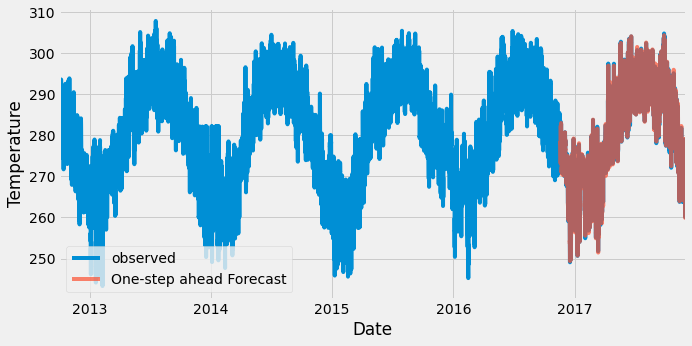

In [14]:
#plot real against predicted values
ax = weather_df['Temperature'].plot(label='observed')
ts_results['Predicted'].plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(10, 5))

ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
plt.legend()
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

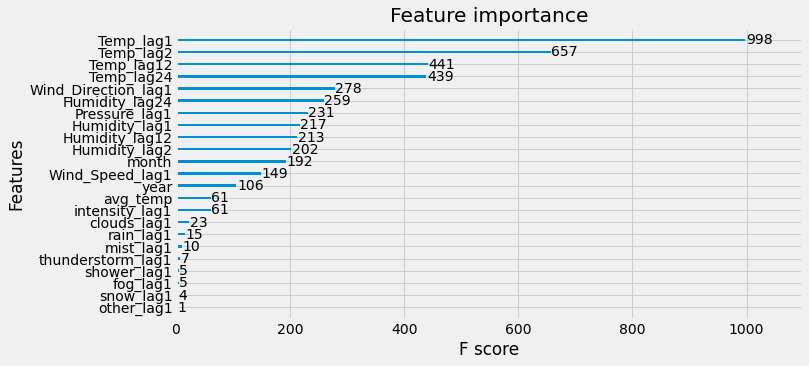

In [15]:
plt.figure(figsize=(10,5))
xgb.plot_importance(xgb_model, ax=plt.gca())

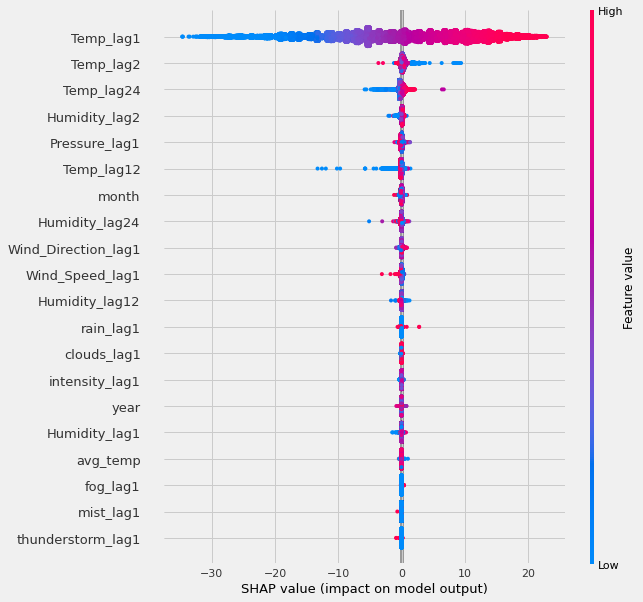

In [16]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

## Drop some features and run again

Seems like nothing much changed from the full set, which makes sense since XGB is pretty good at evaluating which predictors are important or not. However, the XGBoost with only the temperature variable still performs slightly better, possibly because the signal is clearer.

In [36]:
ml_df2 = ml_df.copy()
ml_df2.drop(['other_lag1','fog_lag1','shower_lag1','snow_lag1','thunderstorm_lag1','mist_lag1','rain_lag1','clouds_lag1'], axis = 1, inplace = True)
ml_df2.head()

,Temperature,month,year,Temp_lag1,Temp_lag2,Temp_lag12,Temp_lag24,Humidity_lag1,Humidity_lag2,Humidity_lag12,Humidity_lag24,Wind_Direction_lag1,Pressure_lag1,Wind_Speed_lag1,intensity_lag1,avg_temp
datetime,,,,,,,,,,,,,,,,
2012-10-02 13:00:00,286.13686,10,2012,286.123721,286.110581,285.979185,285.830000,7.000000,11.000000,49.0,93.0,1016.424953,261.0,0.0,0.0,274
2012-10-02 14:00:00,286.15000,10,2012,286.136860,286.123721,285.992325,285.834650,71.861538,7.000000,45.0,91.0,1016.424953,262.0,0.0,0.0,274
2012-10-02 15:00:00,287.55000,10,2012,286.150000,286.136860,286.005465,285.847790,71.861538,71.861538,42.0,87.0,1016.424953,264.0,0.0,0.0,275
2012-10-02 16:00:00,288.14000,10,2012,287.550000,286.150000,286.018604,285.860929,82.000000,71.861538,38.0,84.0,1002.000000,280.0,5.0,3.0,275
2012-10-02 17:00:00,288.69000,10,2012,288.140000,287.550000,286.031744,285.874069,71.861538,82.000000,34.0,80.0,1016.424953,276.0,1.0,0.0,276


In [32]:
y = ml_df2[['Temperature']] #small typo fix here SL
X = ml_df2.drop('Temperature', axis =1) #small typo fix here SL

def train_test_split(data, n_test):
    return data[:n_test], data[n_test:]

split_len = int(len(ml_df2)*0.80) #small typo fix here SL

X_train, X_test = train_test_split(X, split_len)
y_train, y_test = train_test_split(y, split_len)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled)
X_train.columns = X.columns

X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled)
X_test.columns = X.columns

In [33]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(n_estimators=1000)
xgb_model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric = 'rmse',
        early_stopping_rounds=50,
       verbose=False) 

pred = xgb_model.predict(X_test)

In [34]:
ts_results = pd.DataFrame({'Predicted': pred, 'Observed': y_test['Temperature']})
ts_results[ts_results['Predicted'] <= 0] = 0
ts_results['RMSE'] = np.sqrt((ts_results['Predicted']-ts_results['Observed'])**2)
ts_results['RMSE'].mean()

0.6240249059502319

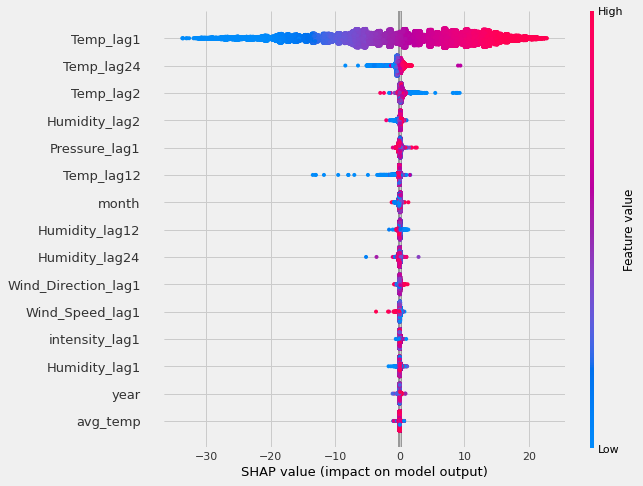

In [35]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

## Hyperparameter Tuning 

We perform Bayesian optimization for finding the best hyperparameters using HYPEROPT, which searches through the hyperparameter space of values and finds the best possible values that minimizes the loss function.

In [186]:
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn import metrics

In [187]:
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

In [188]:
def tune_model(space): 
    xgb_model = xgb.XGBRegressor(n_estimators =space['n_estimators'], 
                                 max_depth = int(space['max_depth']), 
                                 gamma = space['gamma'],
                                 reg_alpha = int(space['reg_alpha']),
                                 min_child_weight=int(space['min_child_weight']),
                                colsample_bytree=int(space['colsample_bytree']))
        
    xgb_model.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            eval_metric = 'rmse',
            early_stopping_rounds=50,
            verbose=False) 

    pred = xgb_model.predict(X_test)
    #pred = pred.reshape(len(pred),1)
    MSE = metrics.mean_squared_error(y_test, pred)
    print('MSE', MSE)
    return {'loss': MSE, 'status': STATUS_OK}

In [189]:
trials = Trials()

best_hyperparams = fmin(fn = tune_model,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

MSE                                                    
7.424414176735229                                      
MSE                                                                             
7.410996082038712                                                               
MSE                                                                             
7.369120516011939                                                               
MSE                                                                             
7.374571585210336                                                               
MSE                                                                             
7.39897036429697                                                                
MSE                                                                             
7.4074419100878695                                                              
MSE                                                                           

In [190]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.7650071206748864, 'gamma': 7.626593207665473, 'max_depth': 7.0, 'min_child_weight': 3.0, 'reg_alpha': 67.0, 'reg_lambda': 0.6339479375279921}


In [194]:
best_hyperparams

{'colsample_bytree': 0.7650071206748864,
 'gamma': 7.626593207665473,
 'max_depth': 7.0,
 'min_child_weight': 3.0,
 'reg_alpha': 67.0,
 'reg_lambda': 0.6339479375279921}

In [209]:
xgb_model = xgb.XGBRegressor(n_estimators=1000,
                             colsample_bytree = 0.765,
                             gamma = 7.62659,
                             max_depth = 7,
                             min_child_weight = 3.0,
                             reg_alpha = 67.0,
                             reg_lambda = 0.6339)

xgb_model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric = 'rmse',
        early_stopping_rounds=50,
       verbose=False) 

pred = xgb_model.predict(X_test)

In [210]:
ts_results = pd.DataFrame({'Predicted': pred, 'Observed': y_test['Temperature']})
ts_results[ts_results['Predicted'] <= 0] = 0
ts_results['RMSE'] = np.sqrt((ts_results['Predicted']-ts_results['Observed'])**2)
ts_results['RMSE'].mean()

0.6252758632320766

## Hyperparameter Tuning on Base Model

In [223]:
X_train = X_train[['month','year','Temp_lag1','Temp_lag2','Temp_lag12','Temp_lag24']]
X_test = X_test[['month','year','Temp_lag1','Temp_lag2','Temp_lag12','Temp_lag24']]

In [224]:
trials = Trials()

best_hyperparams = fmin(fn = tune_model,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

MSE                                                    
2.179811424002658                                      
MSE                                                                             
2.067141674486046                                                               
MSE                                                                             
2.147133993353651                                                               
MSE                                                                             
2.1917996737232306                                                              
MSE                                                                             
2.0969103254271904                                                              
MSE                                                                             
2.1146963147507116                                                              
MSE                                                                           

In [225]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.8817698784787885, 'gamma': 5.846920982388518, 'max_depth': 4.0, 'min_child_weight': 1.0, 'reg_alpha': 40.0, 'reg_lambda': 0.6361100339020545}


In [226]:
xgb_model = xgb.XGBRegressor(n_estimators=1000,
                             colsample_bytree = 0.88,
                             gamma = 5.85,
                             max_depth = 4,
                             min_child_weight = 1.0,
                             reg_alpha = 40.0,
                             reg_lambda = 0.64)

xgb_model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric = 'rmse',
        early_stopping_rounds=50,
       verbose=False) 

pred = xgb_model.predict(X_test)

In [227]:
ts_results = pd.DataFrame({'Predicted': pred, 'Observed': y_test['Temperature']})
ts_results[ts_results['Predicted'] <= 0] = 0
ts_results['RMSE'] = np.sqrt((ts_results['Predicted']-ts_results['Observed'])**2)
ts_results['RMSE'].mean()

0.6194637762228973

We see above that hyperparameter tuning has minimal effect on the model. There are two possible explanations: the first being that the model's existing performance is already quite high RMSE = ~0.61-0.62; the second being that the features used to predict the temperature are much more important than the hyperparameters themselves.